## 权重衰减

权重衰减等价于 $L2$ 范数正则化（regularization）。正则化通过为模型损失函数添加惩罚项使学出的模型参数值较小，是应对过拟合的常用手段。

以$3.1$节（线性回归）中的线性回归损失函数:
<center>
$l(w_1,w_2,b)= $ $ \frac{1}{n} \sum_{i=1}^n \frac{1}{2}(\hat{y}^{(i)}-y^{(i)})^2 $ $ =\frac{1}{n} \sum_{i=1}^n \frac{1}{2}({x}^{(i)}_1\times w_1+{x}^{(i)}_2\times w_2+b-y^{(i)})^2$
</center>
带有L_2范数惩罚项的新损失函数为：
<center>
$ l(w_1,w_2,b)+\frac{\lambda}{2n}||\mathbf{w}||^2 $
</center>

其中超参数$\lambda>0$。当权重参数为$0$时，惩罚项最小。当较大时，惩罚项在损失函数中的比重较大，这通常会使学到的权重参数的元素较接近于$0$。上式中$L_2$范数平方展开后得到$ w_1^2+w_2^2 $。有了$L_2$范数惩罚项后，在小批量随机梯度下降中，我们将线性回归一节中权重$w_1$和$w_2$的迭代方式更改为：
<center>
    $ w_1 \leftarrow (1-\frac{\eta\lambda}{|\beta|})w_1-\frac{\eta}{|\beta|}\sum\limits_{i\epsilon\beta}x_1^{(i)}(x_1^{(i)}w_1+x_2^{(i)}w_2+b-y^{(i)}) $
</center>
<center>
    $ w_2 \leftarrow (1-\frac{\eta\lambda}{|\beta|})w_2-\frac{\eta}{|\beta|}\sum\limits_{i\epsilon\beta}x_2^{(i)}(x_1^{(i)}w_1+x_2^{(i)}w_2+b-y^{(i)}) $
</center>

可见，$L_2$ 范数正则化令权重$w_1$和$w_2$先**自乘小于$1$的数**，再减去不含惩罚项的梯度。因此，$L_2$ 范数正则化又叫权重衰减。

**高维线性回归实验**

使用如下的线性函数生成该样本的标签：
<center>
    $ y=0.05+\sum_{i=1}^p0.01x_i+\epsilon $
</center>
其中噪声项服从均值为$0$，标准差为$0.01$的正态分布。为了较容易的观察过拟合，我们考虑高维线性回归问题，如设维度$p=200$;同时，我们特意把训练数据集的样本数设低，如$20$。

In [1]:
%matplotlib inline
import torch
import torch.nn as nn
import numpy as np
import sys
sys.path.append("..")
import d2lzh_pytorch as d2l

n_train, n_test, num_inputs = 20,100,200
true_w, true_b = torch.ones(num_inputs,1)*0.01, 0.05

features = torch.randn((n_train+n_test,num_inputs))
labels = torch.mm(features,true_w)+true_b
labels += torch.tensor(np.random.normal(0,0.01,size=labels.size()),dtype=torch.float)
train_features, test_features = features[:n_train,:], features[n_train:,:]
train_labels, test_labels=labels[:n_train], labels[n_train:]

初始化模型参数

In [2]:
def init_param():
    w = torch.randn((num_inputs,1),requires_grad=True)
    b = torch.zeros(1, requires_grad=True)
    return [w,b]

定义$L_2$范数惩罚项

In [3]:
def l2_penalty(w):
    return (w**2).sum()/2

定义训练和测试

In [4]:
batch_size, epochs, lr = 1, 100, 0.003
net, loss = d2l.linreg, d2l.squared_loss

dataset = torch.utils.data.TensorDataset(train_features, train_labels)
train_iter = torch.utils.data.DataLoader(dataset, batch_size, shuffle = True)

def fit_and_plot(lambd):
    w, b = init_param()
    train_ls, test_ls = [],[]
    for _ in range(1,epochs+1):
        for X,y in train_iter:
            l = loss(net(X,w,b),y) + lambd * l2_penalty(w)
            l=l.sum()
            
            if w.grad is not None:
                w.grad.data.zero_()
                b.grad.data.zero_()
            l.backward()
            d2l.sgd([w,b],lr,batch_size)
        train_ls.append(loss(net(train_features,w,b),train_labels).mean().item())
        test_ls.append(loss(net(test_features,w,b),test_labels).mean().item())
    d2l.semilogy(range(1, epochs + 1), train_ls, 'epochs', 'loss',
                 range(1, epochs + 1), test_ls, ['train', 'test'])
    print('L2 norm of w:', w.norm().item())

L2 norm of w: 13.361266136169434


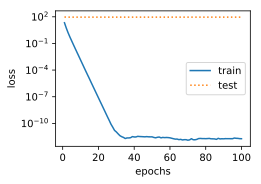

In [5]:
# lambd=0
fit_and_plot(lambd=0)

L2 norm of w: 0.04408494010567665


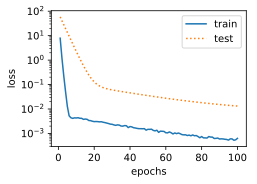

In [6]:
# 权重衰减
fit_and_plot(lambd=3)

**简洁实现**

在构造优化器时可以通过$weight\_decay$参数指定权重衰减超参数。默认对权重和偏置都会衰减。但是可以选择只对权重衰减。

In [7]:
def fit_and_plot_pytorch(wd):
    net = nn.Linear(num_inputs,1)
    nn.init.normal_(net.weight, mean=0, std=1)
    nn.init.normal_(net.bias, mean=0, std=1)
    optimizer_w = torch.optim.SGD(params=[net.weight], lr=lr, weight_decay=wd)
    optimizer_b = torch.optim.SGD(params=[net.bias], lr=lr)
    train_ls, test_ls = [],[]
    for _ in range(epochs):
        for X,y in train_iter:
            l = loss(net(X),y).mean()
            optimizer_w.zero_grad()
            optimizer_b.zero_grad()
            
            l.backward()
            
            optimizer_b.step()
            optimizer_w.step()
        train_ls.append(loss(net(train_features),train_labels).mean().item())
        test_ls.append(loss(net(test_features),test_labels).mean().item())
    d2l.semilogy(range(1, epochs + 1), train_ls, 'epochs', 'loss',
                 range(1, epochs + 1), test_ls, ['train', 'test'])
    print('L2 norm of w:', net.weight.data.norm().item())

L2 norm of w: 14.079629898071289


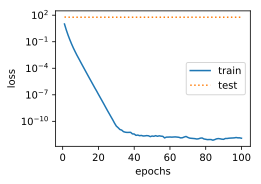

In [8]:
fit_and_plot_pytorch(0)

L2 norm of w: 0.03723355755209923


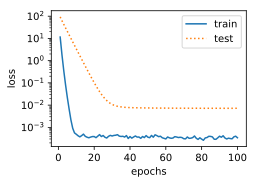

In [9]:
fit_and_plot_pytorch(3)
